In [1]:
from modAL import batch, uncertainty, density, utils
from modAL.models import ActiveLearner
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets, svm, metrics, tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from functools import partial
from typing import Union, Tuple
import pandas as pd

In [15]:
def active_split(X, Y, shuffle=True):
    """
    Split data into three sets:
    * Labeled training set (0.1)
    * Unlabeled training set, to be queried (0.4)
    * Labeled test set (0.5)
    """

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, shuffle=shuffle, random_state=42)
    X_labelled, X_unlabelled, Y_labelled, Y_oracle = train_test_split(X_train, Y_train, test_size=0.95, shuffle=shuffle, random_state=42)

    return X_labelled, X_unlabelled, Y_labelled, Y_oracle, X_test, Y_test

def active_learn(X, y, query_strategy) -> Tuple[list, list]:
    """
    Perform active learning on the given dataset using a linear SVM model, querying data with the given query strategy.

    Returns the accuracy curve.
    """
    X_labelled, X_unlabelled, Y_labelled, Y_oracle, X_test, Y_test = active_split(X, y, shuffle=True)
    learner = ActiveLearner(
        estimator=svm.SVC(kernel='rbf', probability=True), 
        X_training=X_labelled, 
        y_training=Y_labelled, 
        query_strategy=query_strategy
    )

    trained = [len(X_labelled)]
    accuracy = [learner.score(X_test, Y_test)]
    while len(X_unlabelled) != 0:
        query_idx, _ = learner.query(X_unlabelled)
        learner.teach(X_unlabelled[query_idx], Y_oracle[query_idx])
        X_unlabelled = np.delete(X_unlabelled, query_idx, axis=0)
        Y_oracle = np.delete(Y_oracle, query_idx, axis=0)
        trained.append(trained[-1]+10)
        accuracy.append(learner.score(X_test, Y_test))
    return (trained, accuracy)

def random_batch(
    classifier: sklearn.base.BaseEstimator, 
    X: Union[list, np.ndarray], 
    n_instances: int = 1, 
    random_tie_break: bool = False, 
    **uncertainty_measure_kwargs
) -> Tuple[np.ndarray, np.ndarray]:
    idx = np.random.choice(X.shape[0], n_instances)
    return (idx, X[idx])

def query_logger(
    query_func, classifier, X, n_instances=1, **kwargs
) -> Tuple[np.ndarray, np.ndarray]:
    global confidence_query_log
    chosen = query_func(classifier, X, n_instances=n_instances, **kwargs)
    confidence_query_log.append(X[chosen])
    return chosen

def uncertainty_id(clf, X, n_instances=1, **kwargs):
    """
    Sort by the minimum highest confidence labelling.
    """
    return np.argsort(uncertainty.classifier_uncertainty(clf, X) * density.information_density(X))[:n_instances]


In [16]:
def loadData_banknote_complete(dataset_size=1372):
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt'
    dataset = pd.read_csv(url, header=None)
    y = dataset[4].to_numpy()
    isInB = np.array([dataset.to_numpy()[i,0]>0.32 for i in range(len(dataset))])
    isInB = isInB.reshape(len(isInB), 1)
    X = dataset.drop([4], axis=1).to_numpy()
    #pca = PCA(n_components=21).fit(X)
    #X = pca.transform(X)
    X = np.append(X, isInB, axis=1)
    
    return X, y

In [17]:
X, y = loadData_banknote_complete()
# this should have been done by above but *shrug*
X = np.delete(X, 4, axis=1)

In [18]:
query_methods = {
    "uncertainty": batch.uncertainty_batch_sampling,
    "random": random_batch,
    #"margin": uncertainty.margin_sampling,
    #"entropy": uncertainty.entropy_sampling,
    "uncertainty_id": uncertainty_id
}

In [19]:
results = {name: active_learn(X, y, partial(method, n_instances=10)) for name, method in query_methods.items()}

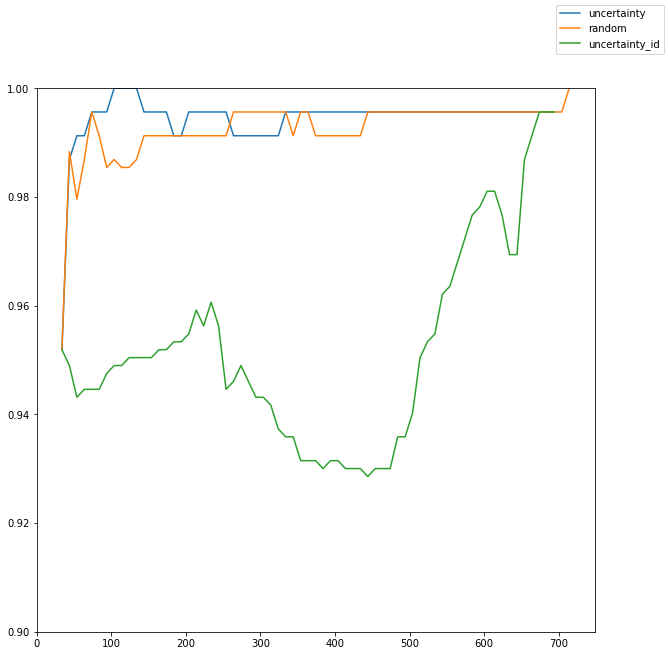

In [23]:
fig, ax = plt.subplots(figsize=(10,10))
for name, result in results.items():
    ax.plot(result[0], result[1], label=name)
    ax.set_ylim(0.9, 1)
fig.legend();

In [8]:
X.shape

(1372, 4)

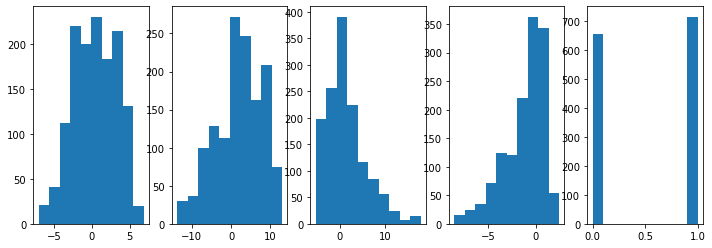

In [59]:
fig, axes = plt.subplots(1,5, figsize=(12, 4))
for i, ax in enumerate(axes.flatten()):
    ax.hist(X[:,i], bins=10)

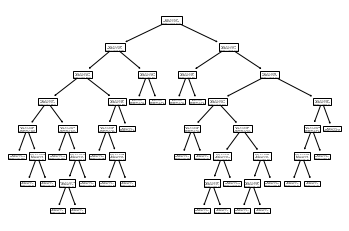

In [62]:
tree_clf = tree.DecisionTreeClassifier()
tree_clf.fit(X, y)
tree.plot_tree(tree_clf);